# Windows 10 Coin

train:  (row: 1,347,190, columns: 1,085)
test:   (row:   374,136, columns: 1,084)

y value: if HasClicked == True, app 1.8%

In [1012]:
# Timer and file info
import math
import time
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import gc # We're gonna be clearing memory a lot
import matplotlib.pyplot as plt
import seaborn as sns
import random
from ml_metrics import mapk
from datetime import datetime
import re
import csv
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import ensemble
from sklearn import cross_validation
from sklearn.metrics import matthews_corrcoef, f1_score, classification_report, confusion_matrix, precision_score, recall_score
%matplotlib inline

# Timer
class Timer:
    def __init__(self, text=None):
        self.text = text
        
    def __enter__(self):
        self.cpu = time.clock()
        self.time = time.time()
        if self.text:
            print("{}...".format(self.text))
            print(datetime.now())
        return self

    def __exit__(self, *args):
        self.cpu = time.clock() - self.cpu
        self.time = time.time() - self.time
        if self.text:
            print("%s: cpu %0.2f, time %0.2f\n" % (self.text, self.cpu, self.time))

In [549]:
def sample_train_holdout(_df, sample_count, holdout_count):   
    random.seed(7)
    sample_RowNumber = random.sample(list(_df['RowNumber']), (sample_count + holdout_count))
    train_RowNumber = random.sample(sample_RowNumber, sample_count)
    holdout_RowNumber = list(set(sample_RowNumber) - set(train_RowNumber))
    holdout = _df[_df['RowNumber'].isin(holdout_RowNumber)].copy()
    _df = _df[_df['RowNumber'].isin(train_RowNumber)]
    return _df, holdout 

In [550]:
# Change date column datetime type and extract date time features
def datetime_features(_df, _col, isDelete = False):
    # 1. For years greater than 2017, create year folder with regex and change year to 2017 in datetime column
    # find and return 4 digit number (1st finding) in dataframe string columns
    year_col = _col + 'Year'
    _df[year_col] = _df[_col].apply(lambda x: int(re.findall(r"\D(\d{4})\D", " "+ str(x) +" ")[0]))
    years = sorted(list(_df[year_col].unique()))
    yearsGreaterThan2017 = sorted(i for i in years if i > 2017)

    # Two ways for strange year data (1) change it to 2017 temporarily (2) remove from data; we will go with (1)
    # because we cannot remove test rows anyway
    if isDelete:
        _df = _df[~_df[year_col].isin(yearsGreaterThan2017)]
    else:
        for i in yearsGreaterThan2017:
            print("replace ", i, " to 2017 for conversion")
            _df.loc[_df[year_col] == i, _col] = _df[_df[year_col] == i][_col].values[0].replace(str(i), "2017")
    
    # How to remove strange year rows
    # train = train[~train['year'].isin(yearsGreaterThan2017)]

    # 2. Convert string to datetime
    _df[_col] = pd.to_datetime(_df[_col])
    print(_col, "column conversion to datetime type is done")
    
    # 3. Add more date time features
    month_col = _col + 'Month'
    week_col = _col + 'Week'
    weekday_col = _col + 'Weekday'
    day_col = _col + 'Day'
    hour_col = _col + 'Hour'
    _df[month_col] = pd.DatetimeIndex(_df[_col]).month
    _df[week_col] = pd.DatetimeIndex(_df[_col]).week
    _df[weekday_col] = pd.DatetimeIndex(_df[_col]).weekday
    _df[day_col] = pd.DatetimeIndex(_df[_col]).day
    _df[hour_col] = pd.DatetimeIndex(_df[_col]).hour
    print("year, month, week, weekday, day, hour features are added")
    
    return _df

In [874]:
# feature engineering functions for dataframe

# Delete rows with list condition for dataframe
def delRows(_df, _col, _list):
    _df = _df[~_df[_col].isin(_list)]
    return _df

import re

# Create new column using regex pattern for strings for dataframe
def addFeatureRegex(_df, _col, _newCol):
    _df[_newCol] = _df[_col].apply(lambda x: int(re.findall(r"\D(\d{4})\D", " "+ str(x) +" ")[0]))
    return _df

# Convert string to datetime type
def stringToDatetime(_df, _col):
    _df[_col] = _df[_col].astype('datetime64[ns]')
    return _df

# Add features from datetime
def addDatetimeFeatures(_df, _col):
    _df[_col + 'Year'] = pd.DatetimeIndex(_df[_col]).year
    _df[_col + 'Month'] = pd.DatetimeIndex(_df[_col]).month
    _df[_col + 'Week'] = pd.DatetimeIndex(_df[_col]).week
    _df[_col + 'Weekday'] = pd.DatetimeIndex(_df[_col]).weekday
    _df[_col + 'Day'] = pd.DatetimeIndex(_df[_col]).day
    _df[_col + 'Hour'] = pd.DatetimeIndex(_df[_col]).hour
    return _df

# Get categorical column names
def categoricalColumns(_df):
    cat_columns = _df.select_dtypes(['object']).columns
    print("Categorical column count:", len(cat_columns))
    print("First 5 values:", cat_columns[:5])
    return cat_columns

# Get column names starting with
def columnsStartingWith(_df, _str):
    sorted_list = sorted(i for i in list(_df) if i.startswith(_str))
    print("Categorical column count:", len(sorted_list))
    print("First 5 values:", sorted_list[:5])    
    return sorted_list

# Get column names ending with
def columnsEndingWith(_df, _str):
    sorted_list = sorted(i for i in list(_df) if i.endswith(_str))
    print("Categorical column count:", len(sorted_list))
    print("First 5 values:", sorted_list[:5])    
    return sorted_list

# Get constant columns
def constantColumns(_df):
    constant_list = []
    cols = list(_df) # same as _df.columns.values
    for col in cols:
        if len(_df[col].unique()) == 1:
            constant_list.append(col)
    print("Constant column count:", len(constant_list))
    print("First 5 values:", constant_list[:5])  
    return constant_list

# Add null columns
def makeNullColumns(_df, _cols):
    null_df = _df[_cols].isnull()
    null_df.columns = null_df.columns + 'Null'
    _df = pd.concat([_df, null_df], axis=1)
    return _df

# Union
def union(a, b):
    return list(set(a)|set(b))

def unique(a):
    return list(set(a))

#_num means folds, 2 means 50%, 5 means 80%, 10 means 90%
def underSampling(_df, _sample_rate):
    _df['isUnderSampled'] = 1
    _rand_num = 1/(1-_sample_rate)
    underSample = np.random.randint(_rand_num, size=len(_df[_df['HasClicked'] == 0]))
    _df.loc[_df['HasClicked'] == 0, 'isUnderSampled'] = underSample>0
    return _df

In [632]:
with Timer("Read train data..."):
    train = pd.read_csv('../input/CoinMlCompetitionSoftlandingTrainWithHeader.tsv', sep='\t') # (1347190, 1085)
    gc.collect()

Read train data......
2017-03-17 01:09:14.834615


C:\Users\hyunor\AppData\Local\Continuum\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (2,8,17,33) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Read train data...: cpu 147.83, time 147.83



In [633]:
# if you want to submit with whole data train, change to False
isSampling = True

if isSampling:
    with Timer("Sampling with holdout..."):
        train, holdout = sample_train_holdout(train, sample_count = 400000, holdout_count = 200000)

        print(train.shape)
        print(holdout.shape)

        gc.collect()

Sampling with holdout......
2017-03-17 01:11:52.954565
(400000, 1085)
(200000, 1085)
Sampling with holdout...: cpu 6.40, time 6.41



In [913]:
# Get column groups and features
all_columns = list(train)
print("All columns:", len(all_columns))

# Remove constant columns for train (all included in time_ and days_ columns)
print("features without constant columns")
constant_columns = constantColumns(train)
features = list(set(all_columns) - set(constant_columns))
print("features:", len(features))

# With a lot of nulls, exclude first and check later for improvement
print("features without time_ and days_ columns")
time_columns = columnsStartingWith(train, 'Time_')
days_columns = columnsStartingWith(train, 'Days_')
features = list(set(features) - set(time_columns))
features = list(set(features) - set(days_columns))
print("features:", len(features))

All columns: 1103
features without constant columns
Constant column count: 62
First 5 values: ['Time_microsoft_basicattractloop', 'Days_microsoft_basicattractloop', 'Time_5319275a_whatsapp', 'Days_5319275a_whatsapp', 'Time_5b04b775_356b_4aa0_aaf8_6491ffea5602']
features: 1041
features without time_ and days_ columns
Categorical column count: 517
First 5 values: ['Time_0c72c7cd_217379cb4ae6f', 'Time_0c72c7cd_beta', 'Time_123freesolitaire_exe', 'Time_1cv8_exe', 'Time_2345explorer_exe']
Categorical column count: 517
First 5 values: ['Days_0c72c7cd_217379cb4ae6f', 'Days_0c72c7cd_beta', 'Days_123freesolitaire_exe', 'Days_1cv8_exe', 'Days_2345explorer_exe']
features: 69


In [635]:
with Timer("Read train data..."):
    print("train shape:", train.shape)

    datetime_columns = ['BubbleShownTime', 'FirstUpdatedDate', 'OSOOBEDateTime']
    for col in datetime_columns:
        print(col)
        if train[col].isnull().sum() > 0:
            train[col] = train[col].fillna('1/31/2017 11:40:18 AM')
        train = datetime_features(train, col, False)

    #train = stringToDatetime(train, 'OSOOBEDateTime')
    #train = addDatetimeFeatures(train, 'OSOOBEDateTime')

    print("train shape:", train.shape)

    gc.collect()

Read train data......
2017-03-17 01:13:21.727246
train shape: (400000, 1085)
BubbleShownTime
replace  2018  to 2017 for conversion
replace  2019  to 2017 for conversion
replace  2020  to 2017 for conversion
replace  2023  to 2017 for conversion
replace  2025  to 2017 for conversion
replace  2032  to 2017 for conversion
replace  2037  to 2017 for conversion
replace  2040  to 2017 for conversion
replace  2097  to 2017 for conversion
replace  2112  to 2017 for conversion
replace  2116  to 2017 for conversion
replace  2196  to 2017 for conversion
replace  5400  to 2017 for conversion
BubbleShownTime column conversion to datetime type is done
year, month, weekday, day, hour features are added
FirstUpdatedDate
FirstUpdatedDate column conversion to datetime type is done
year, month, weekday, day, hour features are added
OSOOBEDateTime
replace  2018  to 2017 for conversion
replace  2025  to 2017 for conversion
replace  2116  to 2017 for conversion
replace  3017  to 2017 for conversion
OSOOBEDa

In [636]:
with Timer("Datetime features..."):
    print("holdout shape:", holdout.shape)

    datetime_columns = ['BubbleShownTime', 'FirstUpdatedDate', 'OSOOBEDateTime']
    for col in datetime_columns:
        print(col)
        if holdout[col].isnull().sum() > 0:
            holdout[col] = holdout[col].fillna('1/31/2017 11:40:18 AM')
        holdout = datetime_features(holdout, col, True)

    #train = stringToDatetime(train, 'OSOOBEDateTime')
    #train = addDatetimeFeatures(train, 'OSOOBEDateTime')

    print("holdout shape:", holdout.shape)

    gc.collect()

Datetime features......
2017-03-17 01:17:42.033722
holdout shape: (200000, 1085)
BubbleShownTime


C:\Users\hyunor\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\hyunor\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\hyunor\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

BubbleShownTime column conversion to datetime type is done


C:\Users\hyunor\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


year, month, weekday, day, hour features are added
FirstUpdatedDate
FirstUpdatedDate column conversion to datetime type is done
year, month, weekday, day, hour features are added
OSOOBEDateTime
OSOOBEDateTime column conversion to datetime type is done
year, month, weekday, day, hour features are added
holdout shape: (199986, 1103)
Datetime features...: cpu 98.06, time 98.04



In [912]:
#train_bk = train.copy()
#holdout_bk = holdout.copy()

train = train_bk.copy()
holdout = holdout_bk.copy()

In [914]:
train['CntNs'] = train.isnull().sum(axis=1) 
holdout['CntNs'] = holdout.isnull().sum(axis=1)

In [915]:
cols = ['AppCategoryNMinus1', 'AppCategoryNMinus2', 'AppCategoryNMinus3', 'AppCategoryNMinus4', 'AppCategoryNMinus5',
       'AppCategoryNMinus6', 'AppCategoryNMinus7', 'AppCategoryNMinus8']
train['AppCatCntNs'] = train[cols].isnull().sum(axis=1)
holdout['AppCatCntNs'] = holdout[cols].isnull().sum(axis=1)

In [916]:
features = train.columns
features = list(set(features) - set(['RowNumber', 'HasClicked']))

In [911]:
len(features)

1103

In [880]:
train = makeNullColumns(train, features)

In [881]:
train.shape

(400000, 2208)

In [882]:
holdout = makeNullColumns(holdout, features)

In [883]:
train.head()

,RowNumber,BubbleShownTime,CampaignId,creativeName,UniqueUserDeviceKey,LifeTimeImpressionCount,LifeTimeConversionCount,RecentMonthConversionCount,IsVirtualDevice,ISOCountryShortName,...,IsTouchEnabledNull,Days_fl_exeNull,Days_26720randomsaladgamesllc_simplesolitaireNull,Days_speed_exeNull,Time_conhost_exeNull,Days_rhino_exeNull,Days_microsoft_windows_cortanaNull,Days_vegas130_exeNull,Days_firefox_exeNull,Time_2a4e62d8_8809_4787_89f8_69d0f01654fbNull
4,5,2017-02-14 21:25:06,111000000000270254,[SL] Edge - Switch - Chrome - Performance - We...,228110,3.0,0.0,0.0,False,Australia,...,False,True,True,True,True,True,True,True,True,True
5,6,2017-02-16 04:57:08,89000000000268322,Edge - Meet Edge - Upgraded to RS1,1157265,2.0,0.0,0.0,False,United States,...,False,True,True,True,True,True,True,True,True,True
6,7,2017-02-11 13:21:00,3000000000265412,[SL] Edge - Switch - Chrome - Battery Aggressi...,79974,22.0,0.0,0.0,False,United States,...,False,True,True,True,True,True,False,True,True,True
8,9,2017-02-12 20:46:26,3000000000265650,[SL] Edge - Switch - Chrome - Security - Week ...,79974,22.0,0.0,0.0,False,United States,...,False,True,True,True,True,True,False,True,True,True
11,12,2017-02-12 23:41:06,67000000000266660,Edge-Battery Chrome-Aggressive-RS1 (Copy Update),85200,NaN,NaN,NaN,False,United States,...,False,True,True,True,False,True,False,True,True,True


In [789]:
holdout.head()

,RowNumber,BubbleShownTime,CampaignId,creativeName,UniqueUserDeviceKey,LifeTimeImpressionCount,LifeTimeConversionCount,RecentMonthConversionCount,IsVirtualDevice,ISOCountryShortName,...,CntNs,AppCatCntNs,AppCategoryNMinus1Null,AppCategoryNMinus2Null,AppCategoryNMinus3Null,AppCategoryNMinus4Null,AppCategoryNMinus5Null,AppCategoryNMinus6Null,AppCategoryNMinus7Null,AppCategoryNMinus8Null
0,1,2017-02-14 02:23:35,3000000000265650,[SL] Edge - Switch - Chrome - Security - Week ...,853972,1.0,0.0,0.0,False,Israel,...,958,0,False,False,False,False,False,False,False,False
34,35,2017-02-15 19:06:25,73000000000266902,[SL] Edge - Switch - Chrome - Battery - Aggres...,965616,15.0,0.0,0.0,False,United States,...,976,0,False,False,False,False,False,False,False,False
37,38,2017-02-12 03:11:02,3000000000265412,[SL] Edge - Switch - Chrome - Battery Aggressi...,1125181,7.0,0.0,0.0,False,Canada,...,982,0,False,False,False,False,False,False,False,False
47,48,2017-02-15 03:40:28,111000000000270254,[SL] Edge - Switch - Chrome - Performance - We...,434379,54.0,6.0,0.0,False,Australia,...,960,0,False,False,False,False,False,False,False,False
51,52,2017-02-15 07:50:08,2000000000266460,Id_2000000000266460,1162525,9.0,0.0,0.0,False,China,...,1038,0,False,False,False,False,False,False,False,False


In [771]:
from sklearn.feature_extraction import DictVectorizer as DV
'''
train[cols].fillna('NA', inplace = True )
holdout[cols].fillna('NA', inplace = True )

x_cat_train = train[cols].to_dict( orient = 'records' )
x_cat_holdout = holdout[cols].to_dict( orient = 'records' )

# vectorize
vectorizer = DV( sparse = False )
vec_x_cat_train = vectorizer.fit_transform( x_cat_train )
vec_x_cat_holdout = vectorizer.transform( x_cat_holdout )
'''
#del x_cat_train, x_cat_holdout
#del vec_x_cat_train, vec_x_cat_holdout

#gc.collect()


def one_hot(df, cols):
    """
    @param df pandas DataFrame
    @param cols a list of columns to encode 
    @return a DataFrame with one-hot encoding
    """
    for each in cols:
        dummies = pd.get_dummies(df[each], prefix=each, drop_first=False)
        df = pd.concat([df, dummies], axis=1)
    return df

# **To Do**

# 1. Combine train and test (:)
# 2. Add high level app categories
# 3. One hot encoding for high level app cats
# 4. One hot encoding for detail level app cats
# 5. Count by Categories
# 6. Split to train and test (:)

data=X_train[[col]].append(X_test[[col]])

In [768]:
dummies

,AppCategoryNMinus1_App Components,AppCategoryNMinus1_App Components:Background,AppCategoryNMinus1_App Components:Installer,AppCategoryNMinus1_Books & Reference,AppCategoryNMinus1_Books & Reference:Books,AppCategoryNMinus1_Books & Reference:E-Reader,AppCategoryNMinus1_Books & Reference:Reference,AppCategoryNMinus1_Browser,AppCategoryNMinus1_Business,AppCategoryNMinus1_Business:CRM,...,AppCategoryNMinus1_Utilities & Tools,AppCategoryNMinus1_Utilities & Tools:Accessability,AppCategoryNMinus1_Utilities & Tools:Backup & Manage,AppCategoryNMinus1_Utilities & Tools:Calcs & Converters,AppCategoryNMinus1_Utilities & Tools:Clocks_ Alarms_ & Timers,AppCategoryNMinus1_Utilities & Tools:Downloader,AppCategoryNMinus1_Utilities & Tools:File Managers,AppCategoryNMinus1_Utilities & Tools:Hardware,AppCategoryNMinus1_Utilities & Tools:Remote Access,AppCategoryNMinus1_Utilities & Tools:Start Replacement
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
11,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
16,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
17,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
19,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
26,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [750]:
def union(a, b):
    return list(set(a)|set(b))

def unique(a):
    return list(set(a))

AppCats = []
for col in cols:
    trainCats, holdoutCats = unique(train[col]), unique(holdout[col])
    print(len(trainCats), len(holdoutCats))
    AppCats = union(AppCats, trainCats)
    AppCats = union(AppCats, holdoutCats)
print(len(AppCats))

94 90
91 90
95 87
95 87
92 89
93 89
88 85
91 90
110


In [751]:
AppCats

[nan,
 'Shopping',
 'Lifestyle:Automotive',
 'Comm & Collab',
 'Media:AV Player',
 'Browser',
 'Cloud Storage',
 'Education',
 'Games:Classics',
 'Games:Shooter',
 'Productivity:Design',
 'Media',
 'Business:Sales & Marketing',
 'Medical',
 'Creative:Audio',
 'Developer Tools:Networking',
 'Productivity:Viewer',
 'Games:Family & Kids',
 'Lifestyle',
 'Health & Fitness',
 'Games:Puzzle & Trivia',
 'Games:Simulation',
 'Productivity:Translation',
 'App Components',
 'Productivity:Email & Calendar',
 'Utilities & Tools',
 'Books & Reference:Reference',
 'Lifestyle:Relationships',
 'Kids & Family:Entertainment',
 'Security',
 'Creative:Photo',
 'Games:Educational',
 'Help & Tips',
 'Navigation & Maps',
 'Games',
 'App Components:Background',
 'Business:Data & Analytics',
 'Business:Time & Expenses',
 'Media:Video',
 'Business:Project Management',
 'Lifestyle:Special Interest',
 'News & Weather:News',
 'App Components:Installer',
 'Media:Music',
 'Utilities & Tools:Hardware',
 'Utilities & 

In [917]:
train['GamerSegment1'] = train['GamerSegment'].apply(lambda x: str(x).split('.')[0] if str(x).split('.') else 'Unknown')

In [918]:
holdout['GamerSegment1'] = holdout['GamerSegment'].apply(lambda x: str(x).split('.')[0] if str(x).split('.') else 'Unknown')

In [713]:
train['GamerSegment2'] = train['GamerSegment'].apply(lambda x: str(x).split('.')[1] if len(str(x).split('.')) > 0 else 'Unknown')

IndexError: list index out of range

In [694]:
a = '1,2,3'
print(a.split(','))
print(len(a.split(',')))
print(a.split(',')[0])
print(a.split(',')[1])
print(a.split(',')[2])

['1', '2', '3']
3
1
2
3


In [690]:
train['GamerSegment3'] = train['GamerSegment'].apply(lambda x: str(x).split('.')[2] if str(x).split('.')[2] else 'Unknown')

IndexError: list index out of range

In [701]:
train.GamerSegment.unique()

array(['NoGaming.NoGaming.DX12Discrete',
       'NoGaming.NoGaming.DX12Integrated',
       'GamingOtherHardware.8OrMoreDaysGaming.DX12Integrated',
       'GamingOtherHardware.UpTo7DaysGaming.DX12Integrated',
       'NoGaming.NoGaming.DX11Integrated',
       'GamingHardware.8OrMoreDaysGaming.DX11Discrete',
       'GamingOtherHardware.UpTo7DaysGaming.DX11Integrated',
       'GamingHardware.8OrMoreDaysGaming.DX12Discrete',
       'GamingHardware.UpTo7DaysGaming.DX11Discrete',
       'GamingOtherHardware.8OrMoreDaysGaming.Other',
       'NoGaming.NoGaming.Other',
       'GamingHardware.UpTo7DaysGaming.DX12Discrete',
       'NoGaming.NoGaming.DX11Discrete',
       'GamingOtherHardware.8OrMoreDaysGaming.DX11Integrated',
       'GamingOtherHardware.UpTo7DaysGaming.Other', 'Unknown',
       'GamingHardware.8OrMoreDaysGaming.DX12Integrated',
       'GamingHardware.UpTo7DaysGaming.DX12Integrated'], dtype=object)

In [714]:
train['GamerSegment1'].unique()

array(['NoGaming', 'GamingOtherHardware', 'GamingHardware', 'Unknown'], dtype=object)

In [919]:
with Timer("Replace missing value with -1..."):
    train = train.fillna(-1)

Replace missing value with -1......
2017-03-17 18:40:34.001489
Replace missing value with -1...: cpu 2.52, time 2.52



In [920]:
with Timer("Replace missing value with -1..."):
    holdout = holdout.fillna(-1)

Replace missing value with -1......
2017-03-17 18:40:36.548712
Replace missing value with -1...: cpu 1.32, time 1.31



In [921]:
cat_columns = train.select_dtypes(['object']).columns
for cat_column in cat_columns:
    print(cat_column)
    train[cat_column] = train[cat_column].apply(lambda x: abs(hash(x)))
    gc.collect()

CampaignId
creativeName
ISOCountryShortName
DefaultInternetBrowser
IsDomainJoined
IsAlwaysOnAlwaysConnectedCapable
DeviceTimezone
DisplayLanguage
GamerPCClassification
GamerSegment
AppCategoryNMinus1
AppCategoryNMinus2
AppCategoryNMinus3
AppCategoryNMinus4
AppCategoryNMinus5
AppCategoryNMinus6
AppCategoryNMinus7
AppCategoryNMinus8
GamerSegment1


In [922]:
for cat_column in cat_columns:
    print(cat_column)
    holdout[cat_column] = holdout[cat_column].apply(lambda x: abs(hash(x)))
    gc.collect()

CampaignId
creativeName
ISOCountryShortName
DefaultInternetBrowser
IsDomainJoined
IsAlwaysOnAlwaysConnectedCapable
DeviceTimezone
DisplayLanguage
GamerPCClassification
GamerSegment
AppCategoryNMinus1
AppCategoryNMinus2
AppCategoryNMinus3
AppCategoryNMinus4
AppCategoryNMinus5
AppCategoryNMinus6
AppCategoryNMinus7
AppCategoryNMinus8
GamerSegment1


In [923]:
train_y = train['HasClicked'].values
#train.drop('HasClicked', axis = 1, inplace = True)
#train.drop('RowNumber', axis = 1, inplace = True)
#train.drop('BubbleShownTime', axis = 1, inplace = True)
train_y.mean()

0.018437499999999999

In [924]:
y_holdout = holdout['HasClicked'].values

In [925]:
all_columns = list(train)

In [926]:
drop_features = ['HasClicked', 'RowNumber', 'BubbleShownTime', 'FirstUpdatedDate', 'OSOOBEDateTime', 
                 'CampaignUser', 'click_count', 'CampaignUserClickCountBeforeOrAfter']

In [942]:
features = list(set(all_columns) - set(constant_columns))
features = list(set(features) - set(time_columns))
features = list(set(features) - set(days_columns))
features = list(set(features) - set(drop_features))

In [943]:
features

['HasRearFacingCamera',
 'RecentMonthConversionCount',
 'IsPenCapable',
 'IsMalware',
 'FirstUpdatedDateWeek',
 'OSOOBEDateTimeMonth',
 'AppCategoryNMinus1',
 'GamerSegment',
 'GamerPCClassification',
 'UniqueUserDeviceKey',
 'CntNs',
 'AppCategoryNMinus4',
 'TotalPhysicalRAM',
 'OSOOBEDateTimeYear',
 'ProcessorClockSpeed',
 'InternalPrimaryDisplayLogicalDPIY',
 'FirstUpdatedDateYear',
 'ProcessorCores',
 'TotalEngagementTimeInSec',
 'BubbleShownTimeMonth',
 'GamerSegment1',
 'AppCategoryNMinus8',
 'TotalDays',
 'IsAlwaysOnAlwaysConnectedCapable',
 'OSOOBEDateTimeDay',
 'DeviceTimezone',
 'IsCommercial',
 'BubbleShownTimeWeek',
 'AppCategoryNMinus2',
 'FirstUpdatedDateWeekday',
 'OSOOBEDateTimeWeekday',
 'InternalPrimaryDisplayResolutionHorizontal',
 'CampaignId',
 'LifeTimeConversionCount',
 'FirstUpdatedDateHour',
 'FirstUpdatedDateDay',
 'NumberofExternalDisplays',
 'AppCatCntNs',
 'DefaultInternetBrowser',
 'FrontFacingCameraResolution',
 'NumberofInternalDisplays',
 'IsVirtualDevi

In [929]:
impTimeCols = [
'Time_Accessibility',
'Days_Accessibility',
'Time_Browser',
'Days_Browser',
'Time_Communications',
'Days_Communications',
'Time_Content',
'Days_Content',
'Time_DevTools',
'Days_DevTools',
'Time_Games',
'Days_Games',
'Time_Malware',
'Days_Malware',
'Time_Media',
'Days_Media',
'Time_PersonalProductivity',
'Days_PersonalProductivity',
'Time_Readers',
'Days_Readers',
'Time_Search',
'Days_Search',
'Time_Social',
'Days_Social',
'Time_StudentAndLearning',
'Days_StudentAndLearning',
'Time_ModernApps',
'Days_ModernApps',
'Time_Games_Core',
'Days_Games_Core',
'Time_Games_Casual',
'Days_Games_Casual',
'Time_logonui_exe',
'Time_windows_immersivecontrolpanel'
]

In [930]:
#features = union(features, impTimeCols)
'''
train = underSampling(train, 0.5)
train.isUnderSampled.mean()
np.random.randint(5, size=20)
train.shape
'''

In [944]:
from sklearn.model_selection import train_test_split
with Timer('# train validation split'):
    #X_train, X_val, y_train, y_val = train_test_split(train[train.isUnderSampled == True][features], train_y[train.isUnderSampled == True], test_size=0.2, random_state=0)
    X_train, X_val, y_train, y_val = train_test_split(train[features], train_y, test_size=0.2, random_state=0)

# train validation split...
2017-03-17 19:26:51.276240
# train validation split: cpu 0.37, time 0.36



In [945]:
# undersampling for X_train only
'''
print(X_train.shape)
X_train['HasClicked'] = y_train
X_train = underSampling(X_train, 0.98)
y_train = X_train[X_train.isUnderSampled == True]['HasClicked'].values
X_train = X_train[X_train.isUnderSampled == True][features]
print(X_train.shape)
'''

"\nprint(X_train.shape)\nX_train['HasClicked'] = y_train\nX_train = underSampling(X_train, 0.98)\ny_train = X_train[X_train.isUnderSampled == True]['HasClicked'].values\nX_train = X_train[X_train.isUnderSampled == True][features]\nprint(X_train.shape)\n"

In [898]:
gc.collect()

print(y_train.shape)
print(X_train.shape)
print(y_val.shape)
print(X_val.shape)

(320000,)
(320000, 2142)
(80000,)
(80000, 2142)


In [899]:
X_train.head(1)

,Time_utorrent_exe,Time_stellaris_exe,Days_king_com_candycrushjellysagaNull,Days_vmware_view_exe,IsMalware,Time_indesign_exe,Days_servicehostapp_exeNull,Time_Readers,Time_kxetray_exeNull,Days_avimark_exeNull,...,Time_ts4_exeNull,Days_speed_exe,Time_conhost_exe,Days_rhino_exe,Days_microsoft_windows_cortana,Days_vegas130_exe,Days_firefox_exe,Time_logonui_exeNull,Time_Games_CoreNull,GamerSegmentNull
568996,-1.0,-1.0,True,-1.0,-1.0,-1.0,True,-1.0,True,True,...,True,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,True,True,False


In [980]:
rfc = RandomForestClassifier(n_estimators = 100, verbose = 1, min_samples_leaf = 5,
                           min_samples_split =2, max_features=40, max_depth=50, 
                             criterion='entropy', n_jobs=-1, random_state = 1, class_weight = 'balanced')

#scores = cross_validation.cross_val_score(rfc, X_train[features], y_train, scoring='f1', cv=3)
#benchmark = scores.mean()
#print("benchmark: {}".format(benchmark))

rfc.fit(X_train, y_train) 

#n=100
# roc_auc: 0.6270251396194714
# f1 cv: 0.06252398968959812
# f1: 0.10881801125703565


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   36.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.5min finished


Predict...


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.4s finished


In [982]:
f1_score(y_val, y_pred)

0.10881801125703565

Predict...


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.4s finished


predict: 0.108818011257
Predict Probability


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.4s finished


[[ 0.9626252   0.0373748 ]
 [ 0.99085449  0.00914551]
 [ 0.95153594  0.04846406]
 ..., 
 [ 1.          0.        ]
 [ 0.94179903  0.05820097]
 [ 0.94484042  0.05515958]]
0.5
[ 0.0373748   0.00914551  0.04846406 ...,  0.          0.05820097
  0.05515958]
0.0447704507196
f1 score: 0.135912698413
best threshold: 0.192952952953


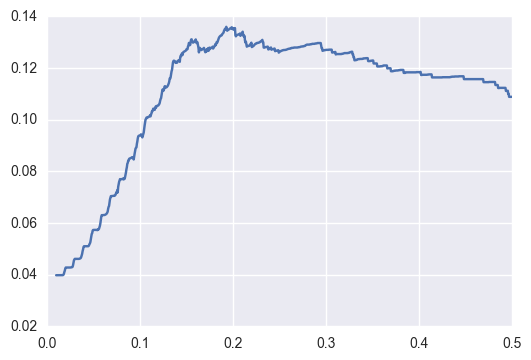

In [1008]:
print('Predict...')
val_preds_rf_tp = rfc.predict(X_val)
print("predict:", f1_score(y_val, val_preds_rf_tp))


print("Predict Probability")
val_preds_rf = rfc.predict_proba(X_val)

print(val_preds_rf)
print(val_preds_rf.mean())

print(val_preds_rf[:,1])
print(val_preds_rf[:,1].mean())

thresholds = np.linspace(0.01, 0.5, 1000)

fc = np.array([f1_score(y_val, val_preds_rf[:,1]>thr) for thr in thresholds])
plt.plot(thresholds, fc)
best_threshold = thresholds[fc.argmax()]
print('f1 score:', fc.max())
print('best threshold:', best_threshold)


In [999]:
X_val.shape

(80000, 67)

In [998]:
holdout.shape

(199986, 1106)

Predict...


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.6s finished


predict: 0.0946015424165
Predict Probability


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.7s finished


[[ 0.96193951  0.03806049]
 [ 0.98060336  0.01939664]
 [ 0.99036027  0.00963973]
 ..., 
 [ 0.98205991  0.01794009]
 [ 0.89299997  0.10700003]
 [ 0.97102475  0.02897525]]
0.5
[ 0.03806049  0.01939664  0.00963973 ...,  0.01794009  0.10700003
  0.02897525]
0.0446037466537
f1 score: 0.125408005497
best threshold: 0.169409409409


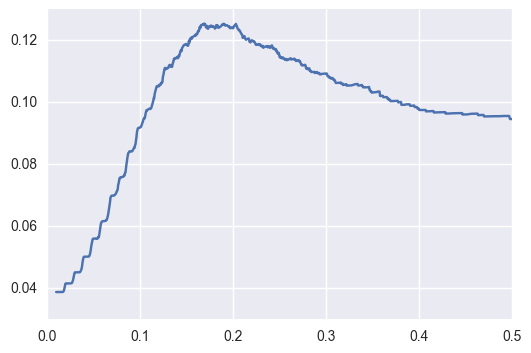

In [1007]:
print('Predict...')
ho_preds_tp = rfc.predict(holdout[features])
print("predict:", f1_score(y_holdout, ho_preds_tp))


print("Predict Probability")
ho_preds_rf = rfc.predict_proba(holdout[features])

print(ho_preds_rf)
print(ho_preds_rf.mean())

print(ho_preds_rf[:,1])
print(ho_preds_rf[:,1].mean())

thresholds = np.linspace(0.01, 0.5, 1000)

fc = np.array([f1_score(y_holdout, ho_preds_rf[:,1]>thr) for thr in thresholds])
plt.plot(thresholds, fc)
best_threshold = thresholds[fc.argmax()]
print('f1 score:', fc.max())
print('best threshold:', best_threshold)

In [1002]:
import lightgbm as lgb
#train_data = lgb.Dataset(X_train[X_train.isUnderSampled == True][features], label=X_train[X_train.isUnderSampled == True]['HasClicked'].values)
train_data = lgb.Dataset(X_train[features], label=y_train)
val_data = lgb.Dataset(X_val[features], y_val)

params = {
    'task' : 'train',
    'boosting_type' : 'dart', #'gbdt', # dart
    'objective' : 'binary',
    'metric' : 'binary_logloss', # binary_logloss, auc
    'is_training_metric': True,
    'max_bin': 255,
    'num_leaves' : 64,
    'learning_rate' : 0.05, #0.05, #0.1,
    'feature_fraction' : 0.8,
    'min_data_in_leaf': 10,
    'min_sum_hessian_in_leaf': 5,
    # 'num_threads': 16,
}
num_round = 5000

In [1003]:
bst = lgb.train(params, train_data, num_round, valid_sets=val_data, early_stopping_rounds=5)

# valid_0's logloss:0.0844732 LB: 0.097603
# valid_0's logloss:0.0744244 (test does not have UserCampaignClickBeforeOrAfter - check further)
#[466]	valid_0's logloss:0.0838359 with null value - strange result in val
#[277]	valid_0's logloss:0.0840156

# binary, auc, [1802]	valid_0's auc:0.700541, LB 0.099
# regression, auc [282]	valid_0's auc:0.686718, f1 local: 0.110575205431, 

#sampling 200k train, 100k val
# binary logloss [127]	valid_0's logloss:0.0891475 f1: 0.0888111888112

# 50% removed     [110]	valid_0's logloss:0.151269 f1: 0.142058533377
# 25% removed    [163]	valid_0's logloss:0.110527 f1: 0.121576888354
# 20% removed    [153]	valid_0's logloss:0.101441 f1: 0.117833135627
# 10% removed    [159]	valid_0's logloss:0.0949685 f1: 0.115059221658
# 5% removed     [159]	valid_0's logloss:0.0985492 f1: 0.100502512563
# 2% removed     [159]	valid_0's logloss:0.0890093 (improve by 0.00014) f1: 0.0981067125645

# train: 320000, val: 80000
# 0% removed   [256]	valid_0's logloss:0.0887238 f1: 0.106930693069 ho: 0.110509448558
# 10% removed  [154]	valid_0's logloss:0.0996627 f1: 0.10612074368 ho: 0.101743589744
# 25% removed  [183]	valid_0's logloss:0.106114 f1: 0.111599594183 ho: 0.103777501038
# 50% removed  [184]	valid_0's logloss:0.149993 f1:0.148806941432, ho: 0.104019390022

# only removed in X_train, not X_val
# 50% removed [233]	valid_0's logloss:0.0938431 f1: 0.0971397733405, ho: 0.11076237724
# 2% removed  [174]	valid_0's logloss:0.0889629 f1: 0.10037921035, ho: 0.108796078062

# Without datetime features
# [162]	valid_0's logloss:0.0892907 f1: 0.0939699448355, ho: 0.101977316069

# n count
# [159]	valid_0's logloss:0.0891557 f1: 0.101081216998, ho: 0.105188845747
# [256]	valid_0's logloss:0.0887238 f1: 0.106930693069, ho: 0.110509448558

#GamerSegment1
# [178]	valid_0's logloss:0.0891189 f1: 0.0998810939358 ho: 0.112030964412

# missing values for 8 appcat (lower score?)
# [179]	valid_0's logloss:0.0890544 f1: 0.0962753212808 ho: 0.107261383247

# days and time
# [228]	valid_0's logloss:0.0889544 f1: 0.104340004497 ho: 0.108139003201

# days and time with null values
# [184]	valid_0's logloss:0.0890757 f1: 0.0990511455682, ho: 0.107537091988

# [126]	valid_0's logloss:0.0896455 f1: 0.091628959276, ho: 0.103537087912



[1]	valid_0's logloss:0.172158
Train until valid scores didn't improve in 5 rounds.
[2]	valid_0's logloss:0.172131
[3]	valid_0's logloss:0.167494
[4]	valid_0's logloss:0.163092
[5]	valid_0's logloss:0.158914
[6]	valid_0's logloss:0.159393
[7]	valid_0's logloss:0.155312
[8]	valid_0's logloss:0.155809
[9]	valid_0's logloss:0.151943
[10]	valid_0's logloss:0.148281
[11]	valid_0's logloss:0.144829
[12]	valid_0's logloss:0.145451
[13]	valid_0's logloss:0.142165
[14]	valid_0's logloss:0.13905
[15]	valid_0's logloss:0.136198
[16]	valid_0's logloss:0.133428
[17]	valid_0's logloss:0.130815
[18]	valid_0's logloss:0.128354
[19]	valid_0's logloss:0.126112
[20]	valid_0's logloss:0.123907
[21]	valid_0's logloss:0.12189
[22]	valid_0's logloss:0.119935
[23]	valid_0's logloss:0.118087
[24]	valid_0's logloss:0.116409
[25]	valid_0's logloss:0.114783
[26]	valid_0's logloss:0.113273
[27]	valid_0's logloss:0.111823
[28]	valid_0's logloss:0.110509
[29]	valid_0's logloss:0.109238
[30]	valid_0's logloss:0.10805

In [1004]:
with Timer('# predict validation data'):
    val_preds = bst.predict(X_val[features], num_iteration=bst.best_iteration)

# predict validation data...
2017-03-17 21:00:16.831512
# predict validation data: cpu 1.82, time 1.81



In [609]:
X_val[features].shape

(80000, 65)

In [610]:
X_train[features].head(1)

,HasRearFacingCamera,RecentMonthConversionCount,IsPenCapable,IsMalware,FirstUpdatedDateWeek,OSOOBEDateTimeMonth,AppCategoryNMinus1,GamerSegment,GamerPCClassification,UniqueUserDeviceKey,...,AppCategoryNMinus5,AppCategoryNMinus7,DisplayLanguage,FirstUpdatedDateMonth,BubbleShownTimeDay,InternalPrimaryDisplayLogicalDPIX,InternalPrimaryDiagonalDisplaySizeInInches,ISOCountryShortName,InternalBatteryNumberOfCharges,PrimaryDiskTotalCapacity
568996,False,-1.0,False,-1.0,6,2,8445571620793378284,2589418488321130521,5505567846788063496,235707,...,437319905459219471,8720560625581583979,3217355243522983290,2,12,96.0,13.3,441420835414083203,0.0,244198.0


In [952]:
val_preds

array([ 0.01909587,  0.0074059 ,  0.02478891, ...,  0.01486564,
        0.01691842,  0.01435461], dtype=float32)

In [156]:
def bestF1Threshold(_y_true, _y_preds, _steps = 100):
    #Find the best threshold (epsilon) to use for selecting outliers
    bestEpsilon = 0
    bestF1 = 0
    bestPrecision = 0
    bestRecall = 0
    F1 = 0

    pval = _y_preds
    yval = _y_true

    stepsize = (max(pval) - min(pval)) / _steps
    print("stepsize:",stepsize)
    print("min:", min(pval))
    print("max:", max(pval))

    #for i in np.arange(0.1, 0.5, 0.01):
    #    print(i)

    for epsilon in np.arange(min(pval), max(pval), stepsize):
    #for epsilon in np.arange(0.02, 0.06, 0.001):
        #print(epsilon)
        predictions = pval > epsilon;
        true_positives = sum((predictions == 1) & (yval == 1))
        false_positives = sum((predictions == 1) & (yval == 0))
        false_negatives = sum((predictions == 0) & (yval == 1))
        precision = true_positives / (true_positives + false_positives)
        recall = true_positives / (true_positives + false_negatives)
        F1 = (2 * (precision * recall)) / (precision + recall)
        #print(epsilon, F1)
        if F1 > bestF1:
            bestF1 = F1
            bestEpsilon = epsilon
            bestPrecision = precision
            bestRecall = recall

    print("bestF1:", bestF1)
    print("bestEpsilon:", bestEpsilon)
    print("bestPrecision:", bestPrecision)
    print("bestRecall:", bestRecall)
    
    return bestF1, bestEpsilon

In [207]:
bestF1, bestEpsilon = bestF1Threshold(y_val, val_preds, 500)

stepsize: 0.00141545701027
min: 0.00407734
max: 0.711806


C:\Users\hyunor\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:29: RuntimeWarning: invalid value encountered in double_scalars


bestF1: 0.120091533181
bestEpsilon: 0.0522028802224
bestPrecision: 0.107664533071
bestRecall: 0.135761589404


[ 0.02239387  0.00675713  0.02386153 ...,  0.01509482  0.01507772
  0.0137758 ]
0.0183197


C:\Users\hyunor\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


0.0998810939358
0.0399199199199


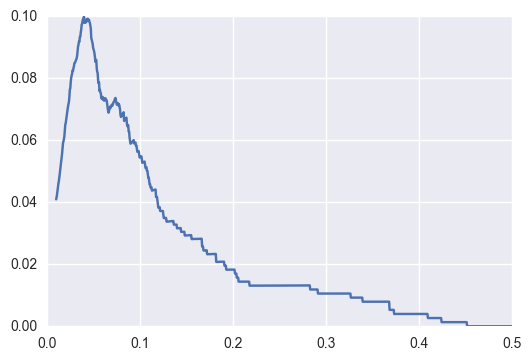

In [1005]:
thresholds = np.linspace(0.01, 0.5, 1000)

print(val_preds)
print(val_preds.mean())

fc = np.array([f1_score(y_val, val_preds>thr) for thr in thresholds])
plt.plot(thresholds, fc)
best_threshold = thresholds[fc.argmax()]
print(fc.max())
print(best_threshold)

# binary, binary_logloss, 0.123654933431, 0.0551251251251
# binary, auc, 0.0976362602551, 0.0585585585586, lr: 0.05
# regression, auc, 0.110575205431, 0.059049049049
# binary, auc, 0.119970738844, 0.0521821821822, lr: 0.02

# predict validation data...
2017-03-17 19:31:52.375664
[ 0.02633726  0.0169428   0.01766082 ...,  0.02426931  0.04314102
  0.05011901]
0.0251962


C:\Users\hyunor\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


0.0972579643269
0.0443343343343
# predict validation data: cpu 34.45, time 34.44



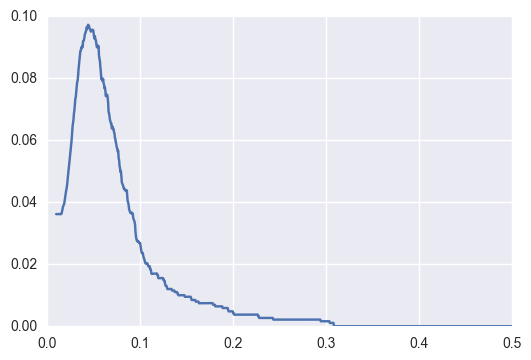

In [959]:
with Timer('# predict validation data'):
    ho_preds = bst.predict(holdout[features], num_iteration=bst.best_iteration)

    print(ho_preds)
    print(ho_preds.mean())
    
    thresholds = np.linspace(0.01, 0.5, 1000)
    fc = np.array([f1_score(y_holdout, ho_preds>thr) for thr in thresholds])
    plt.plot(thresholds, fc)
    best_threshold = thresholds[fc.argmax()]
    print(fc.max())
    print(best_threshold)

0.391267355775
0.484304304304


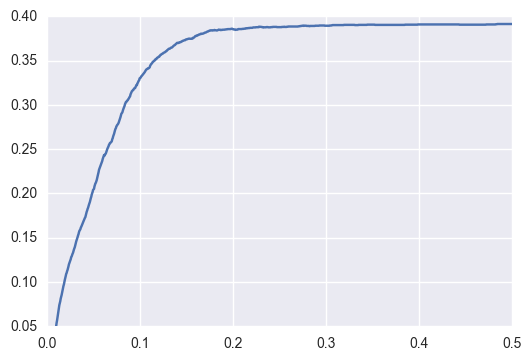

In [84]:
thresholds = np.linspace(0.01, 0.5, 1000)
mcc = np.array([matthews_corrcoef(y_val, val_preds>thr) for thr in thresholds])
plt.plot(thresholds, mcc)
best_threshold_mcc = thresholds[mcc.argmax()]
print(mcc.max())
print(best_threshold_mcc)

[ 0.02239387  0.00675713  0.02386153 ...,  0.01509482  0.01507772
  0.0137758 ]
0.0183197
0.13518696069
0.122322322322


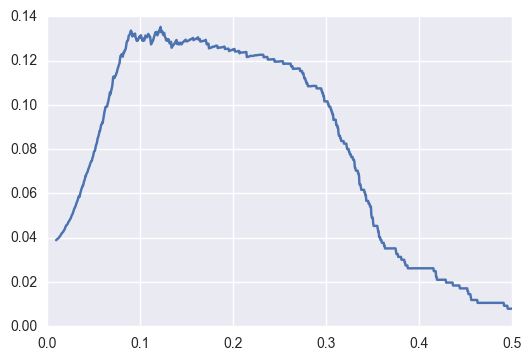

In [1009]:
# Combine data between 

val_preds_rf = val_preds_rf[:,1]

thresholds = np.linspace(0.01, 0.5, 1000)

print(val_preds)
print(val_preds.mean())

fc = np.array([f1_score(y_val, (val_preds*0.5 + val_preds_rf*0.5)>thr) for thr in thresholds])
plt.plot(thresholds, fc)
best_threshold = thresholds[fc.argmax()]
print(fc.max())
print(best_threshold)

[ 0.01586341  0.01007678  0.01169721 ...,  0.01145128  0.03582349
  0.02806327]
0.0183089
0.131484149856
0.114474474474


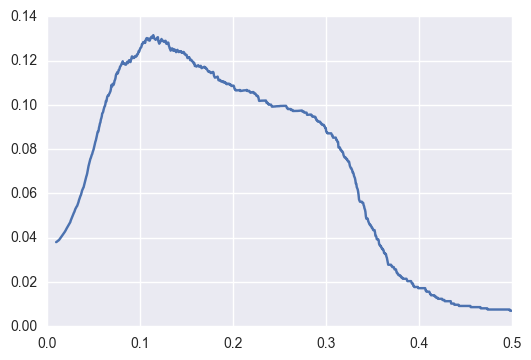

In [1011]:
ho_preds = bst.predict(holdout[features], num_iteration=bst.best_iteration)

ho_preds_rf = ho_preds_rf[:,1]

print(ho_preds)
print(ho_preds.mean())

thresholds = np.linspace(0.01, 0.5, 1000)
fc = np.array([f1_score(y_holdout, (ho_preds * 0.5 + ho_preds_rf * 0.5) >thr) for thr in thresholds])
plt.plot(thresholds, fc)
best_threshold = thresholds[fc.argmax()]
print(fc.max())
print(best_threshold)

In [313]:
bool_preds = np.repeat(False, len(val_preds))
for i, pred in enumerate(val_preds):
    if pred >= 0.0423582170084: #0.045 #0.06
        bool_preds[i] = True

print(bool_preds.mean())

y_true = y_val
y_pred = bool_preds

print("precision: ", precision_score(y_true, y_pred))
print("recall: ", recall_score(y_true, y_pred))

print("TP: ", sum((y_true == 1) & (y_pred == 1)))
print("FP: ", sum((y_true == 0) & (y_pred == 1)))
print("TN: ", sum((y_true == 0) & (y_pred == 0)))
print("FN: ", sum((y_true == 1) & (y_pred == 0)))

print(confusion_matrix(y_true, y_pred))
print("f1_score: %f" % f1_score(y_true, y_pred))
print(classification_report(y_true, y_pred))

# logloss: 0.08679, threshold: 0.0531, fl: 0.071873

0.0292
precision:  0.0616438356164
recall:  0.100840336134
TP:  72
FP:  1096
TN:  38190
FN:  642
[[38190  1096]
 [  642    72]]
f1_score: 0.076514
             precision    recall  f1-score   support

      False       0.98      0.97      0.98     39286
       True       0.06      0.10      0.08       714

avg / total       0.97      0.96      0.96     40000



In [208]:
bst.feature_importance()

array([  47,  381,  172,  269, 2095, 3248, 2137,  892, 6201, 1646, 1569,
        437, 4302,  279,  713,  545, 4065,  283, 1699, 2168,   59, 4578,
       3350,  965, 1871, 1838, 1762, 1192, 5296, 2538, 3716, 3863,  402,
       1692,  725,  238,  139,  331,   37,  595, 1507,  104, 1544, 1227,
       1721, 3705, 4626,  343, 3183, 4084,  300, 1441, 1537, 2179, 2554,
       2712,   57, 3368, 4906, 1807, 2601])

In [210]:
feature_list = X_val[features].columns.values
#feature_dict = dict(zip(range(len(feature_list)), feature_list))
df_fi = pd.DataFrame(bst.feature_importance(), columns=['importance'])
df_fi['feature'] = feature_list
df_fi = df_fi.sort_values('importance', ascending = 0)
df_fi[df_fi.importance >= 10]
#df_fi = df_fi.replace({"feature": feature_dict})

,importance,feature
8,6201,UniqueUserDeviceKey
28,5296,CampaignId
58,4906,ISOCountryShortName
46,4626,creativeName
21,4578,OSOOBEDateTimeDay
12,4302,ProcessorClockSpeed
49,4084,LifeTimeImpressionCount
16,4065,TotalEngagementTimeInSec
31,3863,FirstUpdatedDateDay
30,3716,FirstUpdatedDateHour


In [87]:
with Timer("Read test..."):
    test = pd.read_csv('../input/CoinMlCompetitionSoftlandingEvaluateNoLabel.tsv', sep='\t', header = None)

Read test......
2017-03-15 03:54:49.572362


C:\Users\hyunor\AppData\Local\Continuum\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (2,17,33) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Read test...: cpu 30.24, time 30.24



In [90]:
test.head(5)

,RowNumber,BubbleShownTime,CampaignId,creativeName,UniqueUserDeviceKey,LifeTimeImpressionCount,LifeTimeConversionCount,RecentMonthConversionCount,IsVirtualDevice,ISOCountryShortName,...,Time_Social,Days_Social,Time_StudentAndLearning,Days_StudentAndLearning,Time_ModernApps,Days_ModernApps,Time_Games_Core,Days_Games_Core,Time_Games_Casual,Days_Games_Casual
0,1,2/13/2017 10:52:08 PM,3000000000265650,[SL] Edge - Switch - Chrome - Security - Week ...,10766,3.0,0.0,0.0,False,France,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2/16/2017 3:48:43 PM,111000000000270254,[SL] Edge - Switch - Chrome - Performance - We...,10766,3.0,0.0,0.0,False,France,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2/11/2017 1:21:00 PM,3000000000265412,[SL] Edge - Switch - Chrome - Battery Aggressi...,79975,22.0,0.0,0.0,False,United States,...,NaN,NaN,NaN,NaN,5451.062,8.0,398.532,5.0,NaN,NaN
3,4,2/16/2017 3:52:35 PM,111000000000270254,[SL] Edge - Switch - Chrome - Performance - We...,79975,22.0,0.0,0.0,False,United States,...,NaN,NaN,NaN,NaN,5451.062,8.0,398.532,5.0,NaN,NaN
4,5,2/12/2017 8:46:26 PM,3000000000265650,[SL] Edge - Switch - Chrome - Security - Week ...,79975,22.0,0.0,0.0,False,United States,...,NaN,NaN,NaN,NaN,5451.062,8.0,398.532,5.0,NaN,NaN


In [89]:
test.columns = all_columns[0:1084]
gc.collect()

514

In [91]:
print("train shape:", test.shape)

datetime_columns = ['BubbleShownTime', 'FirstUpdatedDate', 'OSOOBEDateTime']
for col in datetime_columns:
    print(col)
    if test[col].isnull().sum() > 0:
        test[col] = test[col].fillna('1/31/2017 11:40:18 AM')
    test = datetime_features(test, col, False)

#train = stringToDatetime(train, 'OSOOBEDateTime')
#train = addDatetimeFeatures(train, 'OSOOBEDateTime')

print("train shape:", test.shape)

gc.collect()

train shape: (374137, 1084)
BubbleShownTime
replace  2018  to 2017 for conversion
replace  2020  to 2017 for conversion
replace  2023  to 2017 for conversion
replace  2024  to 2017 for conversion
replace  2026  to 2017 for conversion
replace  2038  to 2017 for conversion
replace  2042  to 2017 for conversion
replace  2044  to 2017 for conversion
replace  2047  to 2017 for conversion
replace  2083  to 2017 for conversion
replace  2099  to 2017 for conversion
replace  2183  to 2017 for conversion
replace  3317  to 2017 for conversion
replace  6117  to 2017 for conversion
replace  8017  to 2017 for conversion
BubbleShownTime column conversion to datetime type is done
year, month, day, hour features are added
FirstUpdatedDate
FirstUpdatedDate column conversion to datetime type is done
year, month, day, hour features are added
OSOOBEDateTime
replace  2019  to 2017 for conversion
replace  2051  to 2017 for conversion
replace  2080  to 2017 for conversion
replace  2095  to 2017 for conversion

290

In [99]:
#cat_columns = test.select_dtypes(['object']).columns
for cat_column in cat_columns:
    print(cat_column)
    test[cat_column] = test[cat_column].apply(lambda x: abs(hash(x)))
    gc.collect()

CampaignId
creativeName
IsVirtualDevice
ISOCountryShortName
DefaultInternetBrowser
IsDomainJoined
IsAlwaysOnAlwaysConnectedCapable
DeviceTimezone
DisplayLanguage
GamerPCClassification
GamerSegment
AppCategoryNMinus1
AppCategoryNMinus2
AppCategoryNMinus3
AppCategoryNMinus4
AppCategoryNMinus5
AppCategoryNMinus6
AppCategoryNMinus7
AppCategoryNMinus8


In [158]:
test = test.fillna(-1) # na might work for boost... check later

In [100]:
test['CampaignUser'] = test['CampaignId'].astype(str).str.cat(test['UniqueUserDeviceKey'].astype(str), sep='_')
test['click_count'] = test['CampaignUser'].apply(lambda x: user_campaign_click_dict[x] if x in user_campaign_click_dict else 0)
test['CampaignUserClickCountBeforeOrAfter'] = test['click_count']

In [103]:
test.click_count.mean()
test[test.click_count > 0]
test.shape

(374137, 1102)

In [211]:
with Timer('# predict validation data'):
    preds = bst.predict(test[features], num_iteration=bst.best_iteration)

# predict validation data...
2017-03-15 18:39:38.849866
# predict validation data: cpu 65.92, time 65.92



In [212]:
#print(bestEpsilon)
print(best_threshold)

0.0521821821822


In [213]:
test_id = test.RowNumber.values
submission = pd.DataFrame({'RowNumber': test_id})
submission['HasClicked'] = preds > best_threshold

In [214]:
submission.HasClicked.mean()

0.022371484242403185

In [215]:
submission.head(20)

,RowNumber,HasClicked
0,1,False
1,2,False
2,3,False
3,4,False
4,5,False
5,6,False
6,7,False
7,8,False
8,9,False
9,10,False


In [164]:
gc.collect()

Exception ignored in: <bound method _InnerDataset.__del__ of <lightgbm.basic._InnerDataset object at 0x0000023776079F28>>
Traceback (most recent call last):
  File "C:\Users\hyunor\AppData\Local\Continuum\Anaconda3\lib\site-packages\lightgbm-0.1-py3.5.egg\lightgbm\basic.py", line 651, in __del__
    _safe_call(_LIB.LGBM_DatasetFree(self.handle))
AttributeError: '_InnerDataset' object has no attribute 'handle'


4421

In [216]:
submission.to_csv("AllFeats_datetime_binary_auc_bestThreshold.csv", index = False)
# LB: 0.095695 threshold: 0.05, click mean: 0.027824032373168116, LightGBM logloss:0.0844732
# LB: 0.095919 threshold: 0.051, click mean: 0.02625241555900646, LightGBM logloss:0.0844732
# LB: 0.097603 bestEpsilon: 0.051864455685, click mean: 0.044328681739576679, LightGBM logloss:0.0844732
# LB: 0.09573 best threshold: 0.0521621621622, click mean: 0.024496374322774812, LightGBM logloss:0.0844732
# LB: 0.094498 threshold: 0.053, click mean: 0.023381809337221393, LightGBM logloss:0.0844732

# LB:  threshold: 0.0546346346346, f1: 0.130959110609, click mean: 0.020583369193637624, LightGBM logloss:0.0840156
# By comparing LB and best Epsilon score, best epsilon seems to work as best threshold

In [972]:
import xgboost as xgb

rand_state = 2016

xgparams = {
    'seed': 0,
    'colsample_bytree': 0.9,
    'silent': 1,
    'subsample': 0.85,
    'learning_rate': 0.01,
    'objective': 'binary:logistic', #binary:logistic
    'max_depth': 6,
    'min_child_weight': 12,
    'eval_metric': 'logloss', #rmse
    'booster': 'gbtree'}

d_train = xgb.DMatrix(X_train[features], label=y_train)
d_valid = xgb.DMatrix(X_val[features], label=y_val)

TypeError: can not intialize DMatrix from DataFrame

In [973]:
watchlist = [(d_train, 'train'), (d_valid, 'eval')]

def xg_f1(y,t):
    t = t.get_label()
    y_bin = [1. if y_cont > 0.4952  else 0. for y_cont in y] # binaryzing your output
    #print(y, y_bin)
    return 'f1',f1_score(t,y_bin)

clf = xgb.train(xgparams,
                d_train,
                1000,
                watchlist,
                #eval_metric = xg_f1,
                #feval=xg_f1,
                early_stopping_rounds=5
               )

NameError: name 'd_train' is not defined

In [258]:
with Timer('# predict validation data'):
    xg_preds = clf.predict(d_valid)

# predict validation data...
2017-03-13 10:01:48.632313
# predict validation data: cpu 0.00, time 0.00



In [269]:
bool_preds = np.repeat(False, len(val_preds))
for i, pred in enumerate(xg_preds):
    if pred >= 0.04: #0.045 #0.06
        bool_preds[i] = True

print(bool_preds.mean())

y_true = y_val
y_pred = bool_preds

print("precision: ", precision_score(y_true, y_pred))
print("recall: ", recall_score(y_true, y_pred))

print(confusion_matrix(y_true, y_pred))
print("f1_score: %f" % f1_score(y_true, y_pred))
print(classification_report(y_true, y_pred))

#rmse, cat only, thr = 0.025, f1 = 0.047

0.0355
precision:  0.0485915492958
recall:  0.0966386554622
[[37935  1351]
 [  645    69]]
f1_score: 0.064667
             precision    recall  f1-score   support

      False       0.98      0.97      0.97     39286
       True       0.05      0.10      0.06       714

avg / total       0.97      0.95      0.96     40000

